# LABS Hybrid Solver - MTS Benchmark
CPU vs GPU comparison for Memetic Tabu Search

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Tuple, Callable

try:
    import cupy as cp
    HAS_GPU = cp.cuda.runtime.getDeviceCount() > 0
except:
    cp = None
    HAS_GPU = False

print(f"GPU Available: {HAS_GPU}")
if HAS_GPU:
    print(f"GPU: {cp.cuda.runtime.getDeviceProperties(0)['name'].decode()}")

GPU Available: True
GPU: NVIDIA GeForce RTX 4070 Ti


In [2]:
# ══════════════════════════════════════════════════════════════════════════════
# LABS ENERGY - CPU (NumPy)
# ══════════════════════════════════════════════════════════════════════════════

def labs_energy_cpu(s: np.ndarray) -> int:
    N = len(s)
    E = 0
    for k in range(1, N):
        Ck = np.dot(s[:N-k], s[k:])
        E += Ck * Ck
    return int(E)

def labs_energy_batch_cpu(S: np.ndarray) -> np.ndarray:
    K, N = S.shape
    E = np.zeros(K, dtype=np.int64)
    for k in range(1, N):
        Ck = np.sum(S[:, :N-k] * S[:, k:], axis=1)
        E += Ck * Ck
    return E

In [3]:
# ══════════════════════════════════════════════════════════════════════════════
# LABS ENERGY - GPU (CuPy RawKernel)
# ══════════════════════════════════════════════════════════════════════════════

if HAS_GPU:
    _ENERGY_KERNEL = cp.RawKernel(r'''
    extern "C" __global__
    void labs_energy(const signed char* seqs, long long* energies, int K, int N) {
        int seq_idx = blockIdx.x;
        int lag = threadIdx.x + 1;
        
        long long c_k_sq = 0;
        if (lag < N) {
            int c_k = 0;
            const signed char* row = seqs + (long long)seq_idx * N;
            for (int i = 0; i < N - lag; ++i) c_k += row[i] * row[i + lag];
            c_k_sq = (long long)c_k * c_k;
        }
        
        extern __shared__ long long sdata[];
        sdata[threadIdx.x] = c_k_sq;
        __syncthreads();
        
        for (unsigned int s = blockDim.x / 2; s > 0; s >>= 1) {
            if (threadIdx.x < s) sdata[threadIdx.x] += sdata[threadIdx.x + s];
            __syncthreads();
        }
        if (threadIdx.x == 0) energies[seq_idx] = sdata[0];
    }
    ''', 'labs_energy')

def _next_pow2(n):
    p = 1
    while p < n: p <<= 1
    return p

def labs_energy_batch_gpu(S: cp.ndarray) -> cp.ndarray:
    K, N = S.shape
    if N <= 1: return cp.zeros(K, dtype=cp.int64)
    seqs = cp.ascontiguousarray(S, dtype=cp.int8)
    energies = cp.zeros(K, dtype=cp.int64)
    block = _next_pow2(N - 1)
    _ENERGY_KERNEL((K,), (block,), (seqs, energies, K, N), shared_mem=block * 8)
    return energies

In [4]:
# ══════════════════════════════════════════════════════════════════════════════
# MTS DELTA KERNELS - GPU
# ══════════════════════════════════════════════════════════════════════════════

if HAS_GPU:
    _AUTOCORR_KERNEL = cp.RawKernel(r'''
    extern "C" __global__
    void autocorr(const signed char* seqs, int* autocorrs, int K, int N) {
        int seq_idx = blockIdx.x;
        int lag = threadIdx.x + 1;
        int c_k = 0;
        if (lag < N) {
            const signed char* row = seqs + (long long)seq_idx * N;
            for (int i = 0; i < N - lag; ++i) c_k += row[i] * row[i + lag];
        }
        if (lag < N) autocorrs[(long long)seq_idx * (N - 1) + (lag - 1)] = c_k;
    }
    ''', 'autocorr')

    _DELTA_KERNEL = cp.RawKernel(r'''
    extern "C" __global__
    void delta_energy(const signed char* seqs, const int* autocorrs, 
                      long long* delta_E, int K, int N) {
        int seq_idx = blockIdx.x;
        int j = threadIdx.x;
        if (j >= N) return;
        
        const signed char* row = seqs + (long long)seq_idx * N;
        const int* C = autocorrs + (long long)seq_idx * (N - 1);
        int xj = row[j];
        
        long long energy = 0;
        for (int k = 1; k < N; ++k) {
            int c_k = C[k - 1];
            int contrib = 0;
            if (j - k >= 0) contrib += row[j - k];
            if (j + k < N) contrib += row[j + k];
            int delta_k = -2 * xj * contrib;
            long long new_ck = (long long)(c_k + delta_k);
            energy += new_ck * new_ck;
        }
        delta_E[(long long)seq_idx * N + j] = energy;
    }
    ''', 'delta_energy')

    _UPDATE_KERNEL = cp.RawKernel(r'''
    extern "C" __global__
    void update_autocorr(const signed char* seqs, int* autocorrs, 
                         const int* move_pos, int K, int N) {
        int seq_idx = blockIdx.x;
        int lag = threadIdx.x + 1;
        if (lag >= N) return;
        
        int j = move_pos[seq_idx];
        const signed char* row = seqs + (long long)seq_idx * N;
        int xj = row[j];
        
        int contrib = 0;
        if (j - lag >= 0) contrib += row[j - lag];
        if (j + lag < N) contrib += row[j + lag];
        int delta_k = -2 * xj * contrib;
        autocorrs[(long long)seq_idx * (N - 1) + (lag - 1)] += delta_k;
    }
    ''', 'update_autocorr')

In [5]:
# ══════════════════════════════════════════════════════════════════════════════
# TABU SEARCH - CPU
# ══════════════════════════════════════════════════════════════════════════════

def tabu_search_cpu(seeds: np.ndarray, max_iters: int = 100, tenure: int = 7
                   ) -> Tuple[np.ndarray, int, list]:
    pop = seeds.astype(np.int8, copy=True)
    K, N = pop.shape
    
    E_cur = labs_energy_batch_cpu(pop)
    best_per = pop.copy()
    E_best_per = E_cur.copy()
    
    best_idx = np.argmin(E_cur)
    best_seq = pop[best_idx].copy()
    best_E = int(E_cur[best_idx])
    trace = [best_E]
    
    tabu = np.zeros((K, N), dtype=np.int32)
    ar = np.arange(K)
    
    for it in range(max_iters):
        neigh = np.repeat(pop, N, axis=0)
        rows = np.arange(K * N)
        cols = np.tile(np.arange(N), K)
        neigh[rows, cols] *= -1
        
        E_neigh = labs_energy_batch_cpu(neigh).reshape(K, N)
        
        blocked = tabu > 0
        aspir = E_neigh < E_best_per[:, None]
        blocked = blocked & (~aspir)
        E_masked = E_neigh.astype(np.int64)
        E_masked[blocked] = np.iinfo(np.int64).max
        
        move_pos = np.argmin(E_masked, axis=1)
        move_E = E_neigh[ar, move_pos]
        
        tabu = np.maximum(tabu - 1, 0)
        tabu[ar, move_pos] = tenure
        pop[ar, move_pos] *= -1
        E_cur = move_E
        
        improved = E_cur < E_best_per
        best_per[improved] = pop[improved]
        E_best_per[improved] = E_cur[improved]
        
        idx = np.argmin(E_best_per)
        if E_best_per[idx] < best_E:
            best_E = int(E_best_per[idx])
            best_seq = best_per[idx].copy()
        trace.append(best_E)
    
    return best_seq, best_E, trace

In [6]:
# ══════════════════════════════════════════════════════════════════════════════
# TABU SEARCH - GPU (Delta Kernels)
# ══════════════════════════════════════════════════════════════════════════════

def tabu_search_gpu(seeds: np.ndarray, max_iters: int = 100, tenure: int = 7
                   ) -> Tuple[np.ndarray, int, list]:
    if not HAS_GPU:
        return tabu_search_cpu(seeds, max_iters, tenure)
    
    pop = cp.asarray(seeds, dtype=cp.int8)
    K, N = pop.shape
    
    autocorrs = cp.zeros((K, N - 1), dtype=cp.int32)
    block_ac = _next_pow2(N - 1)
    _AUTOCORR_KERNEL((K,), (block_ac,), (pop, autocorrs, K, N))
    
    E_cur = cp.sum(autocorrs.astype(cp.int64) ** 2, axis=1)
    best_per = pop.copy()
    E_best_per = E_cur.copy()
    
    best_idx = int(cp.argmin(E_best_per))
    best_seq = cp.asnumpy(best_per[best_idx]).astype(np.int8)
    best_E = int(cp.asnumpy(E_best_per[best_idx]))
    trace = [best_E]
    
    tabu = cp.zeros((K, N), dtype=cp.int32)
    delta_E = cp.empty((K, N), dtype=cp.int64)
    block_de = _next_pow2(N)
    ar = cp.arange(K)
    big = cp.int64(cp.iinfo(cp.int64).max)
    
    for it in range(max_iters):
        _DELTA_KERNEL((K,), (block_de,), (pop, autocorrs, delta_E, K, N))
        
        blocked = tabu > 0
        aspir = delta_E < E_best_per[:, None]
        blocked = blocked & (~aspir)
        E_masked = delta_E.copy()
        E_masked[blocked] = big
        
        move_pos = cp.argmin(E_masked, axis=1).astype(cp.int32)
        move_E = delta_E[ar, move_pos]
        
        _UPDATE_KERNEL((K,), (block_ac,), (pop, autocorrs, move_pos, K, N))
        
        tabu = cp.maximum(tabu - 1, 0)
        tabu[ar, move_pos] = tenure
        pop[ar, move_pos] *= -1
        E_cur = move_E
        
        improved = E_cur < E_best_per
        if bool(cp.any(improved)):
            best_per[improved] = pop[improved]
            E_best_per[improved] = E_cur[improved]
        
        idx = int(cp.argmin(E_best_per))
        E_host = int(cp.asnumpy(E_best_per[idx]))
        if E_host < best_E:
            best_E = E_host
            best_seq = cp.asnumpy(best_per[idx]).astype(np.int8)
        trace.append(best_E)
    
    return best_seq, best_E, trace

In [7]:
# ══════════════════════════════════════════════════════════════════════════════
# BENCHMARK RUNNER
# ══════════════════════════════════════════════════════════════════════════════

def benchmark(fn: Callable, seeds: np.ndarray, iters: int, warmup: int = 2, runs: int = 3) -> float:
    for _ in range(warmup):
        fn(seeds.copy(), max_iters=5)
    if HAS_GPU: cp.cuda.Stream.null.synchronize()
    
    times = []
    for _ in range(runs):
        if HAS_GPU: cp.cuda.Stream.null.synchronize()
        t0 = time.perf_counter()
        fn(seeds.copy(), max_iters=iters)
        if HAS_GPU: cp.cuda.Stream.null.synchronize()
        times.append(time.perf_counter() - t0)
    return np.median(times)

In [8]:
# ══════════════════════════════════════════════════════════════════════════════
# RUN BENCHMARKS
# ══════════════════════════════════════════════════════════════════════════════

CONFIGS = [
    (32, 20, 50),   # (K, N, iters)
    (64, 20, 50),
    (128, 20, 50),
    (64, 30, 50),
    (128, 30, 50),
    (256, 30, 50),
]

results = []
print(f"{'K':>6} {'N':>4} {'Iters':>6} {'CPU (s)':>10} {'GPU (s)':>10} {'Speedup':>10}")
print("-" * 52)

for K, N, iters in CONFIGS:
    seeds = np.random.choice([-1, 1], size=(K, N)).astype(np.int8)
    
    t_cpu = benchmark(tabu_search_cpu, seeds, iters)
    t_gpu = benchmark(tabu_search_gpu, seeds, iters) if HAS_GPU else t_cpu
    speedup = t_cpu / t_gpu if t_gpu > 0 else 1.0
    
    results.append({'K': K, 'N': N, 'iters': iters, 'cpu': t_cpu, 'gpu': t_gpu, 'speedup': speedup})
    print(f"{K:>6} {N:>4} {iters:>6} {t_cpu:>10.4f} {t_gpu:>10.4f} {speedup:>9.1f}x")

     K    N  Iters    CPU (s)    GPU (s)    Speedup
----------------------------------------------------
    32   20     50     0.0251     0.0696       0.4x
    64   20     50     0.0413     0.0782       0.5x
   128   20     50     0.0795     0.1176       0.7x
    64   30     50     0.0952     0.0834       1.1x
   128   30     50     0.1844     0.1208       1.5x
   256   30     50     0.3565     0.1216       2.9x


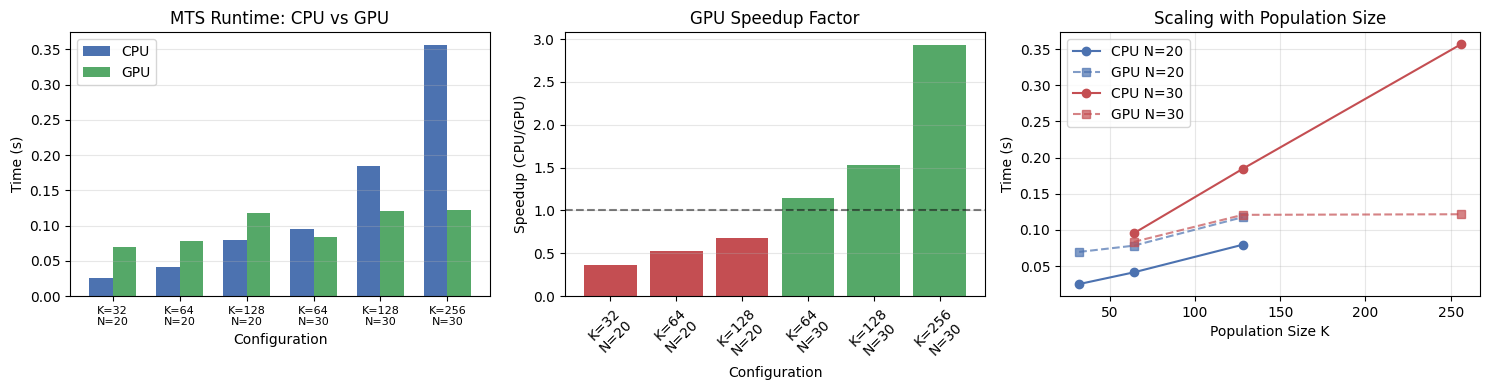

In [9]:
# ══════════════════════════════════════════════════════════════════════════════
# PLOT: CPU vs GPU TIME
# ══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Time comparison bar chart
labels = [f"K={r['K']}\nN={r['N']}" for r in results]
x = np.arange(len(labels))
width = 0.35

ax1 = axes[0]
ax1.bar(x - width/2, [r['cpu'] for r in results], width, label='CPU', color='#4C72B0')
ax1.bar(x + width/2, [r['gpu'] for r in results], width, label='GPU', color='#55A868')
ax1.set_xlabel('Configuration')
ax1.set_ylabel('Time (s)')
ax1.set_title('MTS Runtime: CPU vs GPU')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=8)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Speedup
ax2 = axes[1]
colors = ['#55A868' if s > 1 else '#C44E52' for s in [r['speedup'] for r in results]]
ax2.bar(labels, [r['speedup'] for r in results], color=colors)
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Configuration')
ax2.set_ylabel('Speedup (CPU/GPU)')
ax2.set_title('GPU Speedup Factor')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Scaling with K
ax3 = axes[2]
n20 = [r for r in results if r['N'] == 20]
n30 = [r for r in results if r['N'] == 30]
if n20:
    ax3.plot([r['K'] for r in n20], [r['cpu'] for r in n20], 'o-', label='CPU N=20', color='#4C72B0')
    ax3.plot([r['K'] for r in n20], [r['gpu'] for r in n20], 's--', label='GPU N=20', color='#4C72B0', alpha=0.7)
if n30:
    ax3.plot([r['K'] for r in n30], [r['cpu'] for r in n30], 'o-', label='CPU N=30', color='#C44E52')
    ax3.plot([r['K'] for r in n30], [r['gpu'] for r in n30], 's--', label='GPU N=30', color='#C44E52', alpha=0.7)
ax3.set_xlabel('Population Size K')
ax3.set_ylabel('Time (s)')
ax3.set_title('Scaling with Population Size')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('mts_benchmark.png', dpi=150)
plt.show()

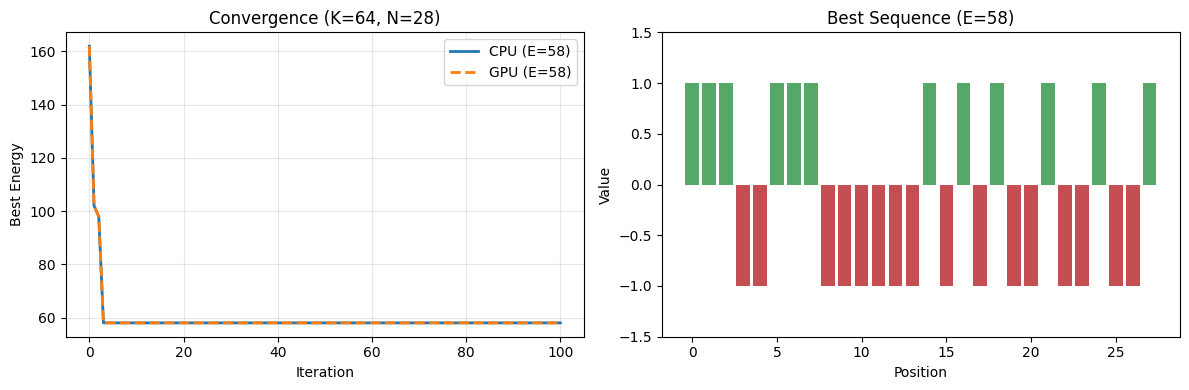

CPU/GPU Parity: ✓ PASS


In [11]:
# ══════════════════════════════════════════════════════════════════════════════
# CONVERGENCE TEST
# ══════════════════════════════════════════════════════════════════════════════

np.random.seed(42)
K, N, iters = 64, 28, 100
seeds = np.random.choice([-1, 1], size=(K, N)).astype(np.int8)

seq_cpu, E_cpu, trace_cpu = tabu_search_cpu(seeds.copy(), max_iters=iters)
seq_gpu, E_gpu, trace_gpu = tabu_search_gpu(seeds.copy(), max_iters=iters)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
ax1.plot(trace_cpu, label=f'CPU (E={E_cpu})', linewidth=2)
ax1.plot(trace_gpu, label=f'GPU (E={E_gpu})', linewidth=2, linestyle='--')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Best Energy')
ax1.set_title(f'Convergence (K={K}, N={N})')
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = axes[1]
ax2.bar(range(N), seq_gpu, color=['#55A868' if s > 0 else '#C44E52' for s in seq_gpu])
ax2.set_xlabel('Position')
ax2.set_ylabel('Value')
ax2.set_title(f'Best Sequence (E={E_gpu})')
ax2.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.savefig('convergence.png', dpi=150)
plt.show()

print(f"CPU/GPU Parity: {'✓ PASS' if E_cpu == E_gpu else '✗ FAIL (may differ due to tie-breaking)'}")

In [12]:
# ══════════════════════════════════════════════════════════════════════════════
# ENERGY KERNEL MICROBENCHMARK
# ══════════════════════════════════════════════════════════════════════════════

if HAS_GPU:
    print("Energy Kernel Benchmark (1000 sequences):")
    print(f"{'N':>6} {'CPU (ms)':>12} {'GPU (ms)':>12} {'Speedup':>10}")
    print("-" * 44)
    
    energy_results = []
    for N in [20, 30, 40, 50, 64]:
        K = 1000
        seeds = np.random.choice([-1, 1], size=(K, N)).astype(np.int8)
        seeds_gpu = cp.asarray(seeds)
        
        # Warmup
        _ = labs_energy_batch_cpu(seeds)
        _ = labs_energy_batch_gpu(seeds_gpu); cp.cuda.Stream.null.synchronize()
        
        # CPU
        t0 = time.perf_counter()
        for _ in range(10): _ = labs_energy_batch_cpu(seeds)
        t_cpu = (time.perf_counter() - t0) / 10 * 1000
        
        # GPU
        cp.cuda.Stream.null.synchronize()
        t0 = time.perf_counter()
        for _ in range(10): _ = labs_energy_batch_gpu(seeds_gpu)
        cp.cuda.Stream.null.synchronize()
        t_gpu = (time.perf_counter() - t0) / 10 * 1000
        
        speedup = t_cpu / t_gpu
        energy_results.append({'N': N, 'cpu': t_cpu, 'gpu': t_gpu, 'speedup': speedup})
        print(f"{N:>6} {t_cpu:>12.3f} {t_gpu:>12.3f} {speedup:>9.1f}x")

Energy Kernel Benchmark (1000 sequences):
     N     CPU (ms)     GPU (ms)    Speedup
--------------------------------------------
    20        0.661        0.092       7.2x
    30        1.059        0.088      12.0x
    40        1.524        0.106      14.3x
    50        1.835        0.114      16.1x
    64        2.824        0.121      23.4x


In [13]:
# ══════════════════════════════════════════════════════════════════════════════
# SUMMARY
# ══════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"\nGPU Available: {HAS_GPU}")
if HAS_GPU:
    avg_speedup = np.mean([r['speedup'] for r in results])
    max_speedup = max(r['speedup'] for r in results)
    print(f"Average MTS Speedup: {avg_speedup:.1f}x")
    print(f"Maximum MTS Speedup: {max_speedup:.1f}x")
    if 'energy_results' in dir():
        avg_energy_speedup = np.mean([r['speedup'] for r in energy_results])
        print(f"Average Energy Kernel Speedup: {avg_energy_speedup:.1f}x")
print("\nFiles saved: mts_benchmark.png, convergence.png")


SUMMARY

GPU Available: True
Average MTS Speedup: 1.2x
Maximum MTS Speedup: 2.9x
Average Energy Kernel Speedup: 14.6x

Files saved: mts_benchmark.png, convergence.png
